In [78]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pylab as plt
import warnings
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
#!pip install hdbscan
import hdbscan
import matplotlib.cm as cm
from matplotlib import colors
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
import seaborn as sns
import math
import random
import plotly.express as px
import plotly.graph_objects as go
random.seed(108448)

# Importing data

## Daily discrete returns of S&P500 companies

In [79]:
# Import companies' list
companies = pd.read_csv('https://raw.githubusercontent.com/petrenaa/petrenaa/main/companies_S&P500.csv', sep = ",")
companies.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [80]:
#Import daily stock prices from Yahoo Finance
prices = pd.read_csv('https://raw.githubusercontent.com/petrenaa/petrenaa/main/prices_S&P500.csv', sep = ",", index_col = 'Date')
prices.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,64.865387,51.647564,98.501442,40.831593,76.580688,86.158249,53.636837,29.433332,141.986420,177.699997,...,154.383667,40.838547,64.321693,63.636124,63.698143,73.990013,115.467537,103.709999,43.121277,69.280342
2018-01-03 00:00:00,66.515816,51.014030,99.392799,40.824478,77.779076,86.478920,53.755444,29.459999,142.641693,181.039993,...,152.711105,40.565212,65.584984,63.418129,64.474861,73.926552,116.267982,105.769997,43.070251,69.598877
2018-01-04 00:00:00,66.016830,51.335663,103.060249,41.014099,77.335503,86.286530,53.664204,29.570000,144.330704,183.220001,...,153.538010,40.249153,65.675758,63.408657,64.905319,74.679131,116.100449,107.860001,43.248856,70.013947
2018-01-05 00:00:00,67.072334,51.316177,104.155830,41.481060,78.681763,87.330978,53.819305,29.453333,145.521301,185.339996,...,154.562225,39.967278,65.622803,64.299591,64.783669,75.114372,117.254562,109.540001,43.265865,70.815178
2018-01-08 00:00:00,67.216270,50.809349,103.422356,41.326996,77.421112,88.778549,53.664204,29.456667,146.684219,185.039993,...,152.504379,40.266243,65.917824,64.735573,65.017609,75.241333,117.477951,110.629997,43.053230,71.664642


In [81]:
#Turn company names to indices in a companies' list
companies.index = companies['Symbol']

In [82]:
#Calculating discrete returns
returns = prices.pct_change(fill_method=None)

In [83]:
#Deleting rows and columns with missing data
del_returns = list(prices.columns[prices.isnull().sum() > 1])
returns.drop(del_returns, axis = 1, inplace = True)
returns.dropna(inplace = True)

## Fama-French factors

In [84]:
ff3 = pd.read_csv('https://raw.githubusercontent.com/petrenaa/petrenaa/main/ff3.CSV', sep = ",", dtype = {'Date': str, 'Mkt-RF': float, 'SMB': float, 'HML': float, 'RF': float})

In [85]:
ff3.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF-%']
ff3['Date'] = pd.to_datetime(ff3['Date'], format = "%Y%m%d") #column Date to a datetime format
ff3.index = ff3['Date'] #Date to indices
ff3 = ff3.loc[:, ff3.columns != 'Date'] #Drop Date
ff3 = ff3 / 100 #from % to numbers
ff3.head()

,Mkt-RF,SMB,HML,RF-%
Date,,,,
2018-01-02,0.0085,0.0035,-0.0021,0.00006
2018-01-03,0.0059,-0.0039,-0.0019,0.00006
2018-01-04,0.0042,-0.0026,0.0025,0.00006
2018-01-05,0.0066,-0.0035,-0.0025,0.00006
2018-01-08,0.0019,-0.0015,0.0004,0.00006


In [86]:
returns.index = pd.to_datetime(returns.index, format = "%Y-%m-%d %H:%M:%S")

##Merging returns and Fama-French factors

In [87]:
analysis = returns.merge(ff3, on = 'Date')
analysis.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XYL,YUM,ZBH,ZBRA,ZION,ZTS,Mkt-RF,SMB,HML,RF-%
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.002211,0.000906,0.004615,0.018796,...,0.012194,-0.000858,0.006932,0.019863,-0.001183,0.004598,0.0059,-0.0039,-0.0019,0.00006
2018-01-04,-0.007502,0.006305,0.036899,0.004645,-0.005703,-0.002225,-0.001697,0.003734,0.011841,0.012042,...,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964,0.0042,-0.0026,0.0025,0.00006
2018-01-05,0.015988,-0.000380,0.010630,0.011385,0.017408,0.012104,0.002890,-0.003945,0.008249,0.011571,...,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444,0.0066,-0.0035,-0.0025,0.00006
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,-0.002882,0.000113,0.007991,-0.001619,...,0.003611,0.001690,0.001905,0.009951,-0.004915,0.011996,0.0019,-0.0015,0.0004,0.00006
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.001700,-0.012900,0.003335,0.008971,...,0.000288,-0.002651,-0.016083,0.030643,0.023509,0.011719,0.0015,-0.0035,-0.0004,0.00006


In [88]:
bc_analysis = analysis.loc[analysis.index < datetime(2020, 2, 1)] #data before COVID-19
ac_analysis = analysis.loc[analysis.index > datetime(2020, 4, 30)] #data after COVID-19

#Fama-French model evaluation

##Before COVID-19

In [89]:
# determine beta vector as well as residuals for each company
tickers = list(returns.columns)
bc_residuals = pd.DataFrame(columns = tickers)
bc_models = dict()
bc_betas = pd.DataFrame(columns = ['Mkt-RF', 'SMB', 'HML'])
bc_X = bc_analysis[['Mkt-RF', 'SMB', 'HML']]
bc_X = sm.add_constant(bc_X)

In [90]:
for company in tickers: #estimate regression models for each company
    bc_y = bc_analysis[company] - bc_analysis['RF-%']
    bc_model = sm.OLS(bc_y, bc_X).fit()
    bc_models[company] = bc_model
    bc_betas.loc[company, :] = bc_model.params[1:].values
    bc_residuals.loc[:, company] = bc_y - bc_model.predict(bc_X)

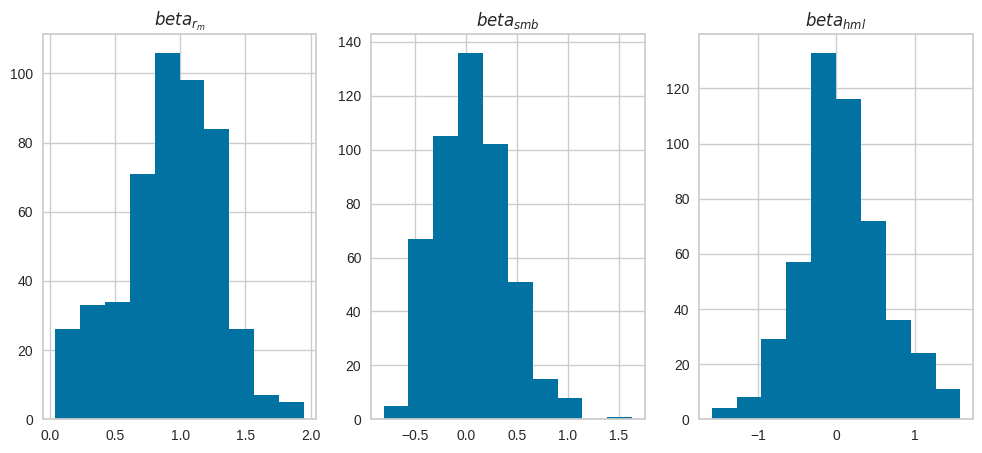

In [91]:
# examine the distribution for each beta factor over all companies

fig, axs = plt.subplots(1, 3, figsize = (12, 5))
bc_betas.loc[:, 'Mkt-RF'].hist(ax = axs[0])
axs[0].set_title(r'$beta_{r_m}$')
bc_betas.loc[:, 'SMB'].hist(ax = axs[1])
axs[1].set_title(r'$beta_{smb}$')
bc_betas.loc[:, 'HML'].hist(ax = axs[2])
axs[2].set_title(r'$beta_{hml}$')
plt.show()

##After COVID-19

In [92]:
# determine beta vector as well as residuals for each company

ac_residuals = pd.DataFrame(columns = tickers)
ac_models = dict()
ac_betas = pd.DataFrame(columns = ['Mkt-RF', 'SMB', 'HML'])
ac_X = ac_analysis[['Mkt-RF', 'SMB', 'HML']]
ac_X = sm.add_constant(ac_X)

In [93]:
for company in tickers: #estimate regression models for each company
    ac_y = ac_analysis[company] - ac_analysis['RF-%']
    ac_model = sm.OLS(ac_y, ac_X).fit()
    ac_models[company] = ac_model
    ac_betas.loc[company, :] = ac_model.params[1:].values
    ac_residuals.loc[:, company] = ac_y - ac_model.predict(ac_X)

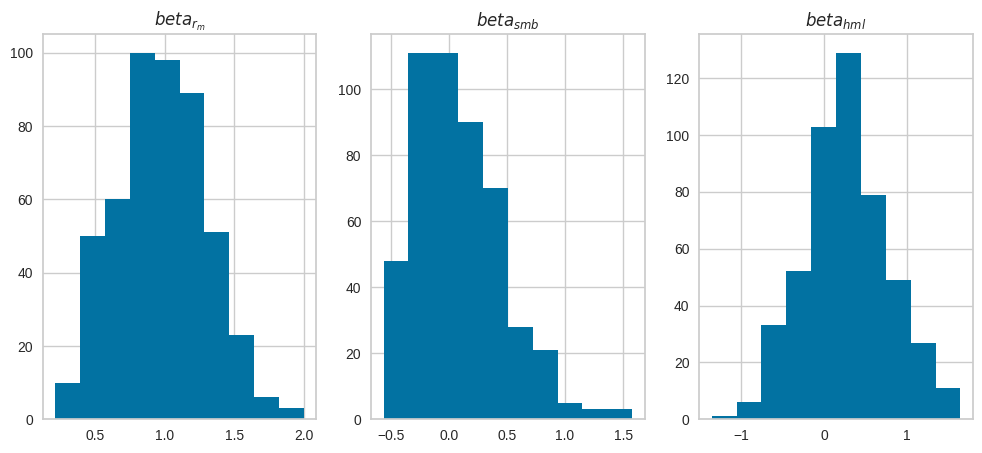

In [94]:
# examine the distribution for each beta factor over all companies

fig, axs = plt.subplots(1, 3, figsize = (12, 5))
ac_betas.loc[:, 'Mkt-RF'].hist(ax = axs[0])
axs[0].set_title(r'$beta_{r_m}$')
ac_betas.loc[:, 'SMB'].hist(ax = axs[1])
axs[1].set_title(r'$beta_{smb}$')
ac_betas.loc[:, 'HML'].hist(ax = axs[2])
axs[2].set_title(r'$beta_{hml}$')
plt.show()

##Comparison

In [95]:
bc_betas.columns = ['Beta Mkt-RF', 'Beta SMB', 'Beta HML'] #rename columns
ac_betas.columns = ['Beta Mkt-RF', 'Beta SMB', 'Beta HML'] #rename columns
print(bc_betas, ac_betas)

     Beta Mkt-RF  Beta SMB  Beta HML
A       1.104099 -0.008052 -0.232202
AAL     1.467816   0.59704  0.379124
AAP     0.786409  0.386944  0.296801
AAPL    1.293202 -0.126728 -0.430565
ABBV    1.015654  -0.24661 -0.118949
...          ...       ...       ...
YUM     0.592636 -0.562231 -0.228679
ZBH     0.855192 -0.012141 -0.248675
ZBRA    1.306125  1.041292 -0.432578
ZION    1.171605  0.531263   1.36043
ZTS     0.909259  -0.24298 -0.486723

[490 rows x 3 columns]      Beta Mkt-RF  Beta SMB  Beta HML
A       0.933991 -0.054032 -0.229389
AAL     1.591107  1.198248  1.145413
AAP     0.853295  0.065554   0.27338
AAPL    1.230291  -0.41886 -0.365256
ABBV    0.467135 -0.361466  0.065246
...          ...       ...       ...
YUM     0.724541 -0.117019  0.155665
ZBH     0.940769  0.168168  0.319699
ZBRA    1.335777  0.123236 -0.082555
ZION    1.381653  0.605859  1.356046
ZTS     0.866501 -0.379274 -0.261996

[490 rows x 3 columns]


#Cluster analysis

##Optimal number of clusters

In [96]:
#Standardize data
st_bc_betas = preprocessing.StandardScaler().fit_transform(bc_betas)
st_bc_betas = pd.DataFrame(st_bc_betas, columns = bc_betas.columns.values, index = bc_betas.index.values)

st_ac_betas = preprocessing.StandardScaler().fit_transform(ac_betas)
st_ac_betas = pd.DataFrame(st_ac_betas, columns = ac_betas.columns.values, index = ac_betas.index.values)

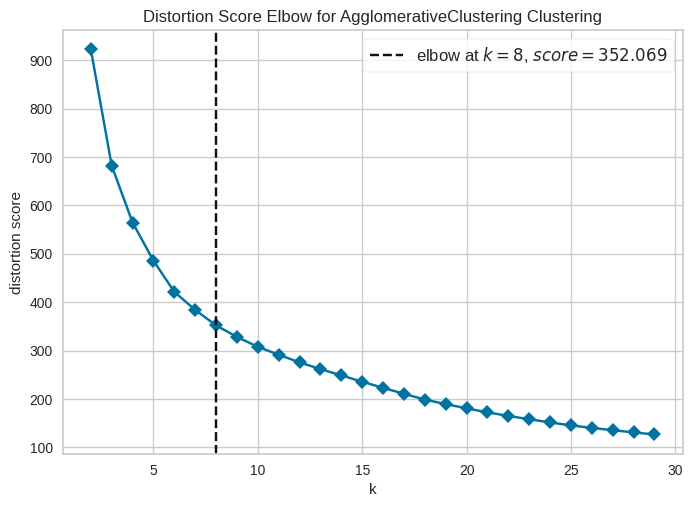

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
#Elbow criterion for hierarchical clustering before COVID-19
random.seed(108448)
model_hier = AgglomerativeClustering(metric = 'euclidean', linkage = 'ward')

# For data before COVID-19
visualizer_hier = KElbowVisualizer(model_hier, k=(2,30), timings = False)
visualizer_hier.fit(st_bc_betas)
visualizer_hier.show()

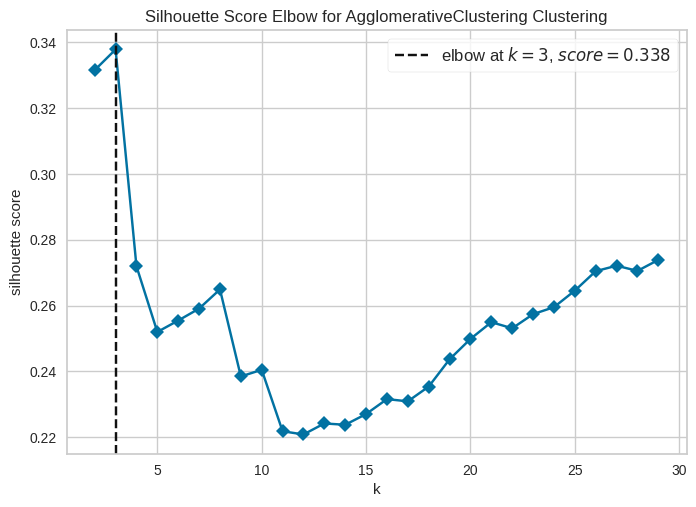

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [98]:
#Silhouette coefficient
visualizer_hier = KElbowVisualizer(model_hier, k=(2,30), timings = False, metric='silhouette')
visualizer_hier.fit(st_bc_betas)
visualizer_hier.show()

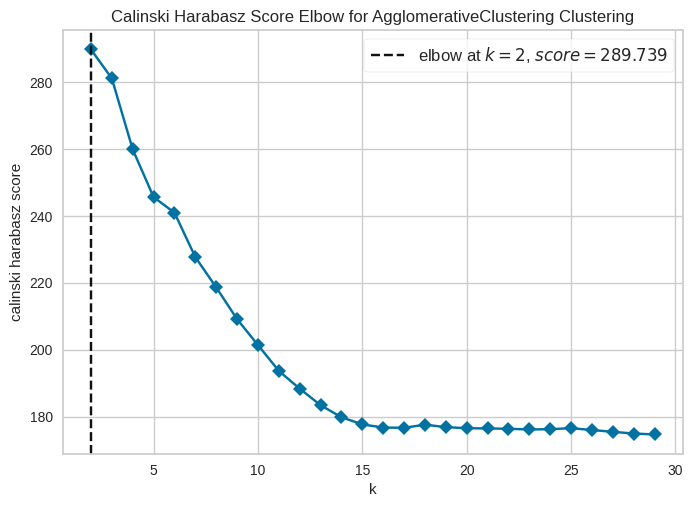

<Axes: title={'center': 'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [99]:
#Calinski-Harabasz Index
visualizer_hier = KElbowVisualizer(model_hier, k=(2,30), timings = False, metric = 'calinski_harabasz')
visualizer_hier.fit(st_bc_betas)
visualizer_hier.show()

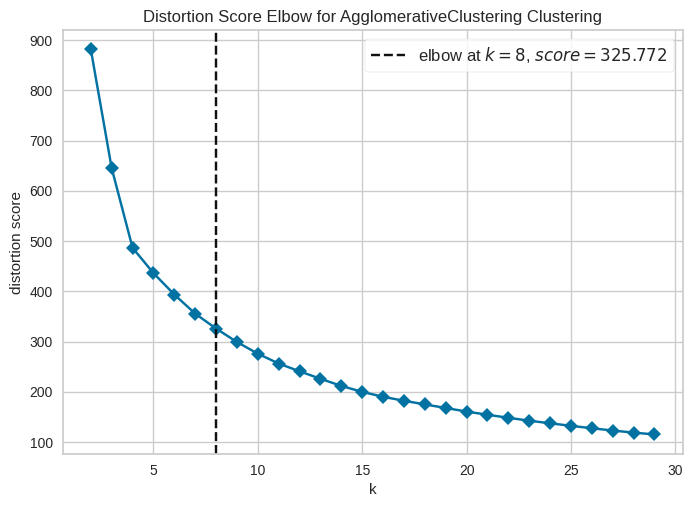

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
#Elbow criterion
# For data after COVID-19
visualizer_hier = KElbowVisualizer(model_hier, k=(2, 30), timings = False)
visualizer_hier.fit(st_ac_betas)
visualizer_hier.show()

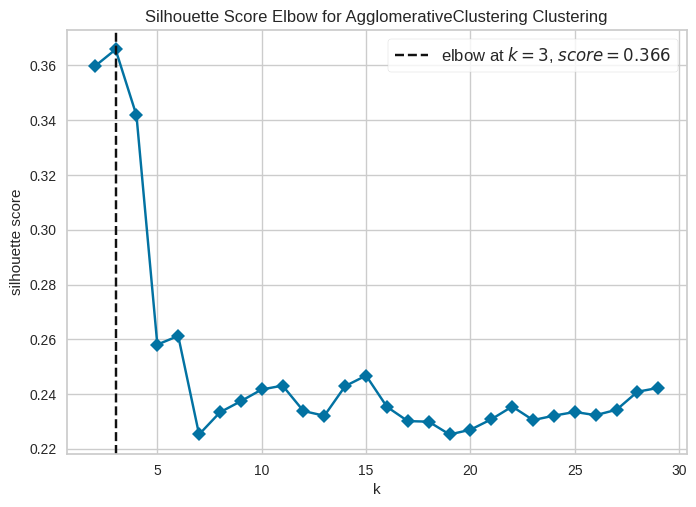

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [101]:
#Silhouette coefficient
visualizer_hier = KElbowVisualizer(model_hier, k=(2, 30), timings = False, metric='silhouette')
visualizer_hier.fit(st_ac_betas)
visualizer_hier.show()

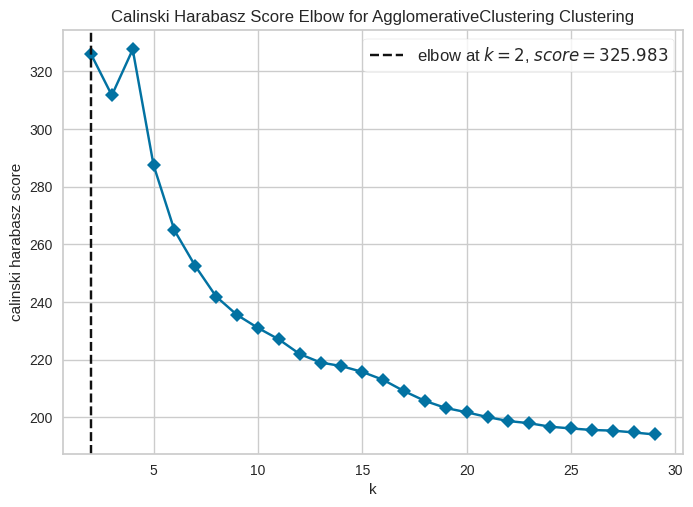

<Axes: title={'center': 'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [102]:
visualizer_hier = KElbowVisualizer(model_hier, k=(2, 30), timings = False, metric ='calinski_harabasz')
visualizer_hier.fit(st_ac_betas)
visualizer_hier.show()

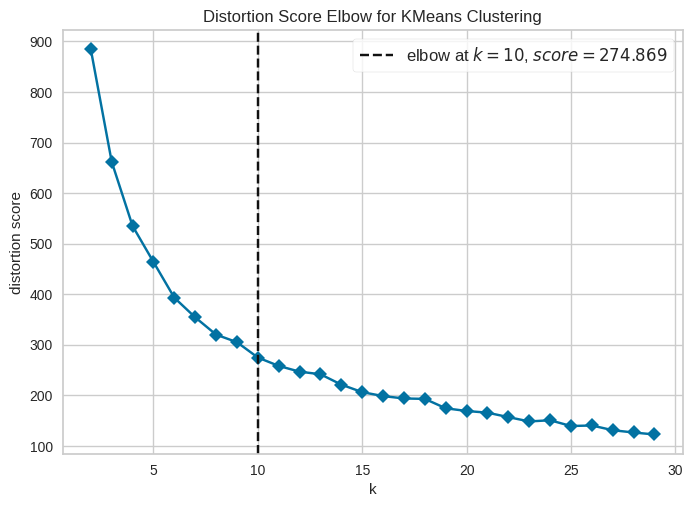

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
#Elbow criterion for k-means
random.seed(108448)
model_kmeans = KMeans(n_init = 'auto')

#For data before COVID-19
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False)
visualizer.fit(st_bc_betas)
visualizer.show()

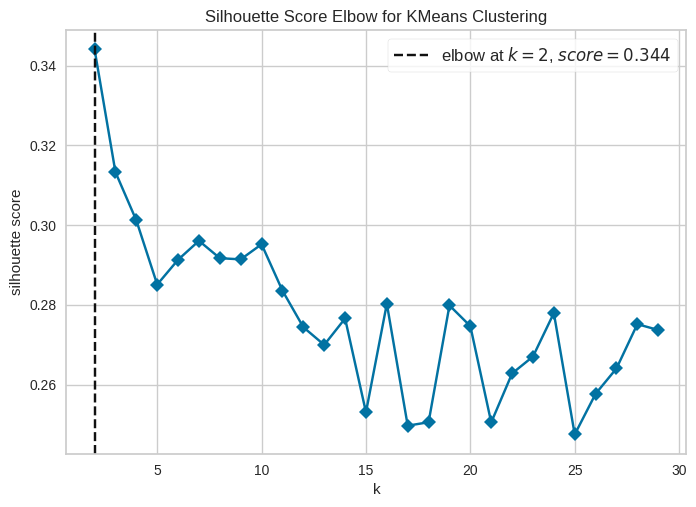

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [104]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric='silhouette')
visualizer.fit(st_bc_betas)
visualizer.show()

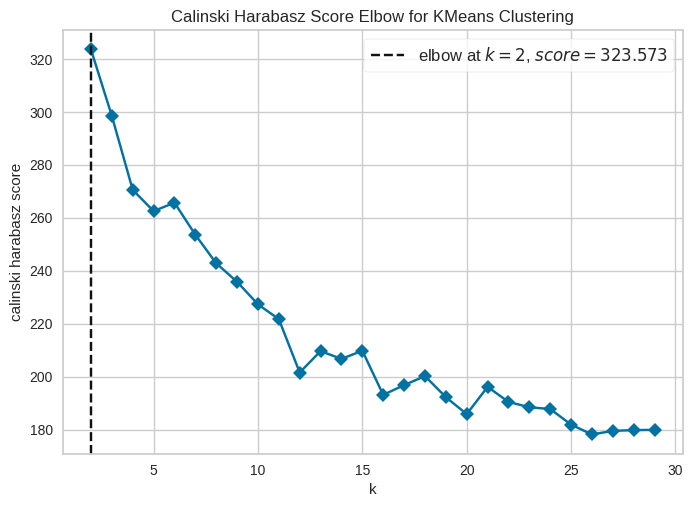

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [105]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric='calinski_harabasz')
visualizer.fit(st_bc_betas)
visualizer.show()

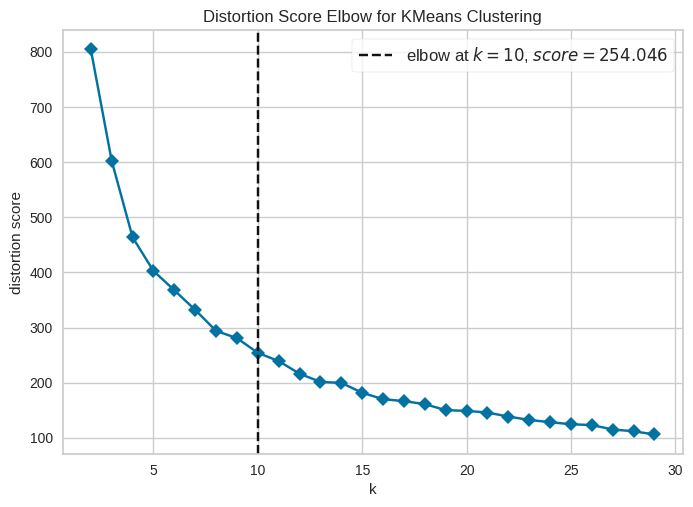

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
#For data after COVID-19
random.seed(108448)
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False)
visualizer.fit(st_ac_betas)
visualizer.show()

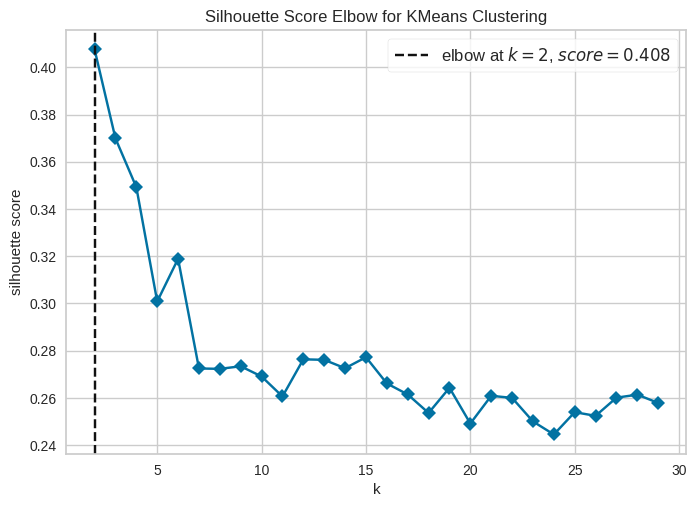

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [107]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric='silhouette')
visualizer.fit(st_ac_betas)
visualizer.show()

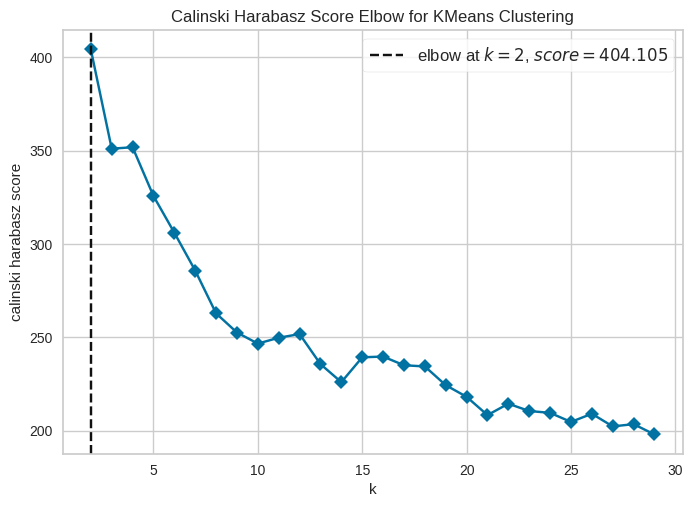

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [108]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric='calinski_harabasz')
visualizer.fit(st_ac_betas)
visualizer.show()

##Before COVID-19

###Hierarchical clustering

In [109]:
#Hierarchical clustering

random.seed(108448)

k = 2
bc_hier = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
bc_betas['Hier'] = bc_hier.fit_predict(st_bc_betas[['Beta HML', 'Beta Mkt-RF', 'Beta SMB']])
pd.pivot_table(bc_betas, index=['Hier'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                             std                      
      Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
Hier                                                                
0    -0.226823    0.771323 -0.102258  0.368279    0.352117  0.292305
1     0.550136    1.171352  0.315973  0.409519    0.227364  0.271088

In [110]:
#Visualizing hierarchical clustering

x = bc_betas['Beta Mkt-RF']
y = bc_betas['Beta SMB']
z = bc_betas['Beta HML']
color = bc_betas['Hier'].astype('category')

fig = px.scatter_3d(bc_betas, x=x, y=y, z=z,
                    color=color)
fig.show()

###K-means

In [111]:
random.seed(108448)

bc_kmeans = KMeans(n_clusters = k, n_init = 'auto')
bc_kmeans.fit(st_bc_betas[['Beta HML', 'Beta Mkt-RF', 'Beta SMB']])
bc_betas['K-means'] = bc_kmeans.labels_
pd.pivot_table(bc_betas, index=['K-means'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                             std                      
         Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
K-means                                                                
0        0.397947    1.170823  0.309905  0.526490    0.238222  0.279822
1       -0.218844    0.704871 -0.166733  0.351739    0.317207  0.232641

In [112]:
#Visualizing k-means clustering

x = bc_betas['Beta Mkt-RF']
y = bc_betas['Beta SMB']
z = bc_betas['Beta HML']
color = bc_betas['K-means'].astype('category')

fig = px.scatter_3d(bc_betas, x=x, y=y, z=z,
                    color=color)
fig.show()

###HDBSCAN

In [113]:
random.seed(108448)

bc_hdbscan = hdbscan.HDBSCAN()
bc_hdbscan.fit(st_bc_betas)
bc_betas['HDBSCAN'] = bc_hdbscan.labels_
pd.pivot_table(bc_betas, index=['HDBSCAN'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



mean                             std                      
         Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
HDBSCAN                                                                
-1       0.154085    1.142366  0.214861  0.813529    0.376473  0.436504
 0       0.020913    0.836936  0.005534  0.368595    0.324491  0.297910
 1       1.026718    1.331902 -0.034194  0.101065    0.073462  0.057469

In [114]:
#Visualizing HDBSCAN clustering

x1 = bc_betas.drop(bc_betas[bc_betas['HDBSCAN'] == -1].index)['Beta Mkt-RF']
y1 = bc_betas.drop(bc_betas[bc_betas['HDBSCAN'] == -1].index)['Beta SMB']
z1 = bc_betas.drop(bc_betas[bc_betas['HDBSCAN'] == -1].index)['Beta HML']
c1 = bc_betas[bc_betas['HDBSCAN'] != -1]['HDBSCAN'].astype('category')


x2 = bc_betas[bc_betas['HDBSCAN'] == -1]['Beta Mkt-RF']
y2 = bc_betas[bc_betas['HDBSCAN'] == -1]['Beta SMB']
z2 = bc_betas[bc_betas['HDBSCAN'] == -1]['Beta HML']
c2 = bc_betas[bc_betas['HDBSCAN'] == -1]['HDBSCAN'].astype('category')


fig = px.scatter_3d(bc_betas, x=x1, y=y1, z=z1, color=c1)

fig.add_trace(
    go.Scatter3d(x=x2, y=y2, z=z2, mode='markers',
        marker=dict(color='gray', size=4, symbol='circle'),
        name='Outliers'))

fig.update_layout(
    scene=dict(
        xaxis_title='Beta Mkt-RF',
        yaxis_title='Beta SMB',
        zaxis_title='Beta HML'
    )
)

fig.show()

##After COVID-19

###Hierarchical clustering

In [115]:
random.seed(108448)

#Hierarchical clustering with k = 2

ac_hier = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
ac_betas['Hier'] = ac_hier.fit_predict(st_ac_betas[['Beta HML', 'Beta Mkt-RF', 'Beta SMB']])
pd.pivot_table(ac_betas, index=['Hier'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                             std                      
      Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
Hier                                                                
0    -0.039617     0.84027 -0.129949  0.340607    0.300376  0.268636
1     0.694714    1.162713  0.367665  0.370050    0.240040  0.298422

In [116]:
#Visualizing hierarchical clustering

x = ac_betas['Beta Mkt-RF']
y = ac_betas['Beta SMB']
z = ac_betas['Beta HML']
color = ac_betas['Hier'].astype('category')

fig = px.scatter_3d(ac_betas, x=x, y=y, z=z,
                    color=color)
fig.show()

###K-means clustering

In [117]:
random.seed(108448)

ac_kmeans = KMeans(n_clusters = k, n_init = 'auto')
ac_kmeans.fit(st_ac_betas[['Beta HML', 'Beta Mkt-RF', 'Beta SMB']])
ac_betas['K-means'] = ac_kmeans.labels_
pd.pivot_table(ac_betas, index=['K-means'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                             std                      
         Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
K-means                                                                
0           0.041     0.81017  -0.14534  0.336111    0.249588  0.191138
1        0.642948    1.240775  0.440338  0.510623    0.222736  0.302960

In [118]:
#Visualizing k-means clustering

x = ac_betas['Beta Mkt-RF']
y = ac_betas['Beta SMB']
z = ac_betas['Beta HML']
color = ac_betas['K-means'].astype('category')

fig = px.scatter_3d(ac_betas, x=x, y=y, z=z,
                    color=color)
fig.show()

###HDBSCAN

In [119]:
ac_hdbscan = hdbscan.HDBSCAN()
ac_hdbscan.fit(st_ac_betas)
ac_betas['HDBSCAN'] = ac_hdbscan.labels_
pd.pivot_table(ac_betas, index=['HDBSCAN'], values=['Beta Mkt-RF', 'Beta SMB', 'Beta HML'], aggfunc = ['mean', 'std']) #mean betas for each cluster

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



mean                             std                      
         Beta HML Beta Mkt-RF  Beta SMB  Beta HML Beta Mkt-RF  Beta SMB
HDBSCAN                                                                
-1       0.162891    1.283918  0.448601  0.758522    0.361862  0.477299
 0       0.323732    0.907221  0.011233  0.413782    0.265722  0.296482
 1      -0.606215    1.216026 -0.181668  0.115400    0.051216  0.132399

In [120]:
#Visualizing HDBSCAN clustering

x1 = ac_betas.drop(ac_betas[ac_betas['HDBSCAN'] == -1].index)['Beta Mkt-RF']
y1 = ac_betas.drop(ac_betas[ac_betas['HDBSCAN'] == -1].index)['Beta SMB']
z1 = ac_betas.drop(ac_betas[ac_betas['HDBSCAN'] == -1].index)['Beta HML']
c1 = ac_betas[ac_betas['HDBSCAN'] != -1]['HDBSCAN'].astype('category')


x2 = ac_betas[ac_betas['HDBSCAN'] == -1]['Beta Mkt-RF']
y2 = ac_betas[ac_betas['HDBSCAN'] == -1]['Beta SMB']
z2 = ac_betas[ac_betas['HDBSCAN'] == -1]['Beta HML']
c2 = ac_betas[ac_betas['HDBSCAN'] == -1]['HDBSCAN'].astype('category')


fig = px.scatter_3d(ac_betas, x=x1, y=y1, z=z1, color=c1)

fig.add_trace(
    go.Scatter3d(x=x2, y=y2, z=z2, mode='markers',
        marker=dict(color='gray', size=4, symbol='circle'),
        name='Outliers'))

fig.update_layout(
    scene=dict(
        xaxis_title='Beta Mkt-RF',
        yaxis_title='Beta SMB',
        zaxis_title='Beta HML'
    )
)

fig.show()

##Clusters comparison

In [121]:
#Add companies names and industries
bc_betas.index.name  = 'Symbol'
bc_betas = pd.merge(bc_betas,
                    companies[['Security', 'GICS Sector', 'GICS Sub-Industry']],
                     how ='left', on = 'Symbol')

ac_betas.index.name  = 'Symbol'
ac_betas = pd.merge(ac_betas,
                    companies[['Security', 'GICS Sector', 'GICS Sub-Industry']],
                     how ='left', on = 'Symbol')

#For pivot
bc_betas['Ticker'] = bc_betas.index
ac_betas['Ticker'] = ac_betas.index

###Similarities between clusters



####Adjusted rand score

In [122]:
methods = ['K-means', 'HDBSCAN', 'Hier']
adjrandscore = pd.DataFrame(columns = methods, index = methods)

print('Adjusted rand score before COVID-19:')
for i in methods:
  for j in methods:
    adjrandscore.loc[i, j] = adjusted_rand_score(bc_betas[i], bc_betas[j])

adjrandscore

Adjusted rand score before COVID-19:


,K-means,HDBSCAN,Hier
K-means,1.0,0.04499,0.639258
HDBSCAN,0.04499,1.0,0.060612
Hier,0.639258,0.060612,1.0


In [123]:
print('Adjusted rand score after COVID-19:')
for i in methods:
  for j in methods:
    adjrandscore.loc[i, j] = adjusted_rand_score(ac_betas[i], ac_betas[j])

adjrandscore

Adjusted rand score after COVID-19:


,K-means,HDBSCAN,Hier
K-means,1.0,0.079932,0.562836
HDBSCAN,0.079932,1.0,0.000905
Hier,0.562836,0.000905,1.0


In [124]:
print('Adjusted rand score before vs. after COVID-19:')
for i in methods:
  for j in methods:
    adjrandscore.loc[i, j] = adjusted_rand_score(bc_betas[i], ac_betas[j])

adjrandscore

Adjusted rand score before vs. after COVID-19:


,K-means,HDBSCAN,Hier
K-means,0.302189,0.037947,0.254634
HDBSCAN,0.090313,0.191062,0.018874
Hier,0.382359,0.037262,0.358189


####Intersection tables

In [125]:
similarity = pd.DataFrame(columns = range(k), index = range(k))

for i in range(k):
  for j in range(k):
    similarity.loc[i, j] = len(pd.merge(bc_betas.loc[bc_betas['K-means'] == i], bc_betas.loc[bc_betas['Hier'] == j], how ='inner', on = 'Ticker'))

print('Similarities between K-means clusters (index) and hierarchical clusters (columns) before COVID-19')
similarity

Similarities between K-means clusters (index) and hierarchical clusters (columns) before COVID-19


,0,1
0,46,187
1,254,3


In [126]:
similarity = pd.DataFrame(columns = range(k), index = range(k))

for i in range(k):
  for j in range(k):
    similarity.loc[i, j] = len(pd.merge(ac_betas.loc[ac_betas['K-means'] == i], ac_betas.loc[ac_betas['Hier'] == j], how ='inner', on = 'Ticker'))

print('Similarities between K-means clusters (index) and hierarchical clusters (columns) after COVID-19')
similarity

Similarities between K-means clusters (index) and hierarchical clusters (columns) after COVID-19


,0,1
0,257,40
1,21,172


In [127]:
similarity = pd.DataFrame(columns = range(k), index = range(k))

for i in range(k):
  for j in range(k):
    similarity.loc[i, j] = len(pd.merge(bc_betas.loc[bc_betas['Hier'] == i], ac_betas.loc[ac_betas['Hier'] == j], how ='inner', on = 'Ticker'))

print('Similarities between hierarchical clusters before COVID (index) and after COVID (columns)')
similarity

Similarities between hierarchical clusters before COVID (index) and after COVID (columns)


,0,1
0,240,60
1,38,152


In [128]:
similarity = pd.DataFrame(columns = range(k), index = range(k))

for i in range(k):
  for j in range(k):
    similarity.loc[i, j] = len(pd.merge(bc_betas.loc[bc_betas['K-means'] == i], ac_betas.loc[ac_betas['K-means'] == j], how ='inner', on = 'Ticker'))

print('Similarities between K-means clusters before COVID (index) and after COVID (columns)')
similarity

Similarities between K-means clusters before COVID (index) and after COVID (columns)


,0,1
0,75,158
1,222,35


In [129]:
v = [-1, 0, 1]
similarity = pd.DataFrame(columns = v, index = v)

for i in v:
  for j in v:
    similarity.loc[i, j] = len(pd.merge(bc_betas.loc[bc_betas['HDBSCAN'] == i], ac_betas.loc[ac_betas['HDBSCAN'] == j], how ='inner', on = 'Ticker'))

print('Similarities between HDBSCAN clusters before COVID (index) and after COVID (columns)')
similarity

Similarities between HDBSCAN clusters before COVID (index) and after COVID (columns)


,-1,0,1
-1,49,75,5
0,37,311,4
1,1,8,0


###Industries analysis

In [130]:
total = bc_betas.merge(ac_betas, on = ['Ticker', 'GICS Sector', 'GICS Sub-Industry', 'Security'])
total.head()

,Beta Mkt-RF_x,Beta SMB_x,Beta HML_x,Hier_x,K-means_x,HDBSCAN_x,Security,GICS Sector,GICS Sub-Industry,Ticker,Beta Mkt-RF_y,Beta SMB_y,Beta HML_y,Hier_y,K-means_y,HDBSCAN_y
0,1.104099,-0.008052,-0.232202,0,1,0,Agilent Technologies,Health Care,Health Care Equipment,A,0.933991,-0.054032,-0.229389,0,0,0
1,1.467816,0.59704,0.379124,1,0,-1,American Airlines Group,Industrials,Passenger Airlines,AAL,1.591107,1.198248,1.145413,1,1,-1
2,0.786409,0.386944,0.296801,1,0,0,Advance Auto Parts,Consumer Discretionary,Automotive Retail,AAP,0.853295,0.065554,0.27338,1,0,0
3,1.293202,-0.126728,-0.430565,0,1,-1,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",AAPL,1.230291,-0.41886,-0.365256,0,0,1
4,1.015654,-0.24661,-0.118949,0,1,0,AbbVie,Health Care,Pharmaceuticals,ABBV,0.467135,-0.361466,0.065246,0,0,0


In [131]:
print('Industries distribution before COVID, K-means')
pd.pivot_table(bc_betas, columns=['K-means'], index = ['GICS Sector'], values = ['Ticker'], aggfunc = pd.Series.nunique)

Industries distribution before COVID, K-means


Ticker      
K-means                     0     1
GICS Sector                        
Communication Services    6.0  15.0
Consumer Discretionary   35.0  18.0
Consumer Staples          4.0  32.0
Energy                   23.0   NaN
Financials               36.0  35.0
Health Care              18.0  44.0
Industrials              53.0  19.0
Information Technology   38.0  28.0
Materials                16.0  11.0
Real Estate               3.0  27.0
Utilities                 1.0  28.0

In [132]:
print('Industries distribution after COVID, K-means')
pd.pivot_table(ac_betas, columns=['K-means'], index = ['GICS Sector'], values = ['Ticker'], aggfunc = pd.Series.nunique)

Industries distribution after COVID, K-means


Ticker      
K-means                     0     1
GICS Sector                        
Communication Services   12.0   9.0
Consumer Discretionary   19.0  34.0
Consumer Staples         34.0   2.0
Energy                    NaN  23.0
Financials               29.0  42.0
Health Care              58.0   4.0
Industrials              44.0  28.0
Information Technology   40.0  26.0
Materials                13.0  14.0
Real Estate              20.0  10.0
Utilities                28.0   1.0

In [133]:
pd.pivot_table(ac_betas.loc[ac_betas['Hier'] == 0], columns=['K-means', 'Hier'],
                    index = ['GICS Sector', 'GICS Sub-Industry'], values = ['Beta HML'], aggfunc = ['mean', pd.Series.nunique])

mean  \
                                                              Beta HML   
K-means                                                              0   
Hier                                                                 0   
GICS Sector            GICS Sub-Industry                                 
Communication Services Cable & Satellite                      0.023205   
                       Integrated Telecommunication Services  0.360047   
                       Interactive Home Entertainment        -0.399518   
                       Interactive Media & Services          -0.372366   
                       Movies & Entertainment                 -0.77197   
...                                                                ...   
Real Estate            Telecom Tower REITs                   -0.187079   
Utilities              Electric Utilities                     0.257328   
                       Gas Utilities                            0.3172   
                       Multi-Utilities                        0.227105   
                       Water Utilities                       -0.079897   

                                                                        \
                                                                         
K-means                                                              1   
Hier                                                                 0   
GICS Sector            GICS Sub-Industry                                 
Communication Services Cable & Satellite                           NaN   
                       Integrated Telecommunication Services       NaN   
                       Interactive Home Entertainment              NaN   
                       Interactive Media & Services          -0.560633   
                       Movies & Entertainment                      NaN   
...                                                                ...   
Real Estate            Telecom Tower REITs                         NaN   
Utilities              Electric Utilities                          NaN   
                       Gas Utilities                               NaN   
                       Multi-Utilities                             NaN   
                       Water Utilities                             NaN   

                                                              nunique       
                                                             Beta HML       
K-means                                                             0    1  
Hier                                                                0    0  
GICS Sector            GICS Sub-Industry                                    
Communication Services Cable & Satellite                          2.0  NaN  
                       Integrated Telecommunication Services      2.0  NaN  
                       Interactive Home Entertainment             3.0  NaN  
                       Interactive Media & Services               3.0  1.0  
                       Movies & Entertainment                     1.0  NaN  
...                                                               ...  ...  
Real Estate            Telecom Tower REITs                        3.0  NaN  
Utilities              Electric Utilities                        13.0  NaN  
                       Gas Utilities                              1.0  NaN  
                       Multi-Utilities                           12.0  NaN  
                       Water Utilities                            1.0  NaN  

[78 rows x 4 columns]

In [134]:
pd.pivot_table(ac_betas.loc[ac_betas['GICS Sector'] == 'Consumer Discretionary'], columns=['K-means', 'Hier'],
                    index = ['GICS Sector', 'GICS Sub-Industry'], values = ['Beta HML'], aggfunc = ['mean', pd.Series.nunique])

mean  \
                                                            Beta HML   
K-means                                                            0   
Hier                                                               0   
GICS Sector            GICS Sub-Industry                               
Consumer Discretionary Apparel Retail                            NaN   
                       Apparel, Accessories & Luxury Goods -0.012662   
                       Automobile Manufacturers                  NaN   
                       Automotive Parts & Equipment              NaN   
                       Automotive Retail                         NaN   
                       Casinos & Gaming                          NaN   
                       Computer & Electronics Retail             NaN   
                       Consumer Electronics                 0.038413   
                       Distributors                        -0.430089   
                       Home Furnishings                          NaN   
                       Home Improvement Retail             -0.074539   
                       Homebuilding                              NaN   
                       Hotels, Resorts & Cruise Lines            NaN   
                       Household Appliances                      NaN   
                       Housewares & Specialties                  NaN   
                       Internet & Direct Marketing Retail  -0.410072   
                       Leisure Products                          NaN   
                       Restaurants                         -0.095914   
                       Specialty Stores                     0.028365   

                                                                      \
                                                                       
K-means                                                                
Hier                                                               1   
GICS Sector            GICS Sub-Industry                               
Consumer Discretionary Apparel Retail                            NaN   
                       Apparel, Accessories & Luxury Goods       NaN   
                       Automobile Manufacturers                  NaN   
                       Automotive Parts & Equipment              NaN   
                       Automotive Retail                     0.27338   
                       Casinos & Gaming                          NaN   
                       Computer & Electronics Retail             NaN   
                       Consumer Electronics                      NaN   
                       Distributors                              NaN   
                       Home Furnishings                          NaN   
                       Home Improvement Retail                   NaN   
                       Homebuilding                         0.084555   
                       Hotels, Resorts & Cruise Lines            NaN   
                       Household Appliances                      NaN   
                       Housewares & Specialties                  NaN   
                       Internet & Direct Marketing Retail        NaN   
                       Leisure Products                     0.316316   
                       Restaurants                               NaN   
                       Specialty Stores                      0.54463   

                                                                      \
                                                                       
K-means                                                            1   
Hier                                                               0   
GICS Sector            GICS Sub-Industry                               
Consumer Discretionary Apparel Retail                            NaN   
                       Apparel, Accessories & Luxury Goods       NaN   
                       Automobile Manufacturers             -0.79148   
                       Automot

In [135]:
# df = pd.pivot_table(bc_betas, index = ['K-means', 'GICS Sector', 'GICS Sub-Industry'], values = ['Ticker'], aggfunc = pd.Series.nunique)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

In [136]:
# df = pd.pivot_table(total, columns=['K-means_x', 'K-means_y'], index = ['GICS Sector', 'GICS Sub-Industry'], values = ['Ticker'], aggfunc = pd.Series.nunique)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#      print(df)

#Appendix

##Analysis of changers

###Beta differences

In [137]:
#Create differences of betas
total['Beta Mkt-RF Diff'] = total['Beta Mkt-RF_y'] - total['Beta Mkt-RF_x']
total['Beta SMB Diff'] =  total['Beta SMB_y'] - total['Beta SMB_x']
total['Beta HML Diff'] = total['Beta HML_y'] - total['Beta HML_x']
total.head()

,Beta Mkt-RF_x,Beta SMB_x,Beta HML_x,Hier_x,K-means_x,HDBSCAN_x,Security,GICS Sector,GICS Sub-Industry,Ticker,Beta Mkt-RF_y,Beta SMB_y,Beta HML_y,Hier_y,K-means_y,HDBSCAN_y,Beta Mkt-RF Diff,Beta SMB Diff,Beta HML Diff
0,1.104099,-0.008052,-0.232202,0,1,0,Agilent Technologies,Health Care,Health Care Equipment,A,0.933991,-0.054032,-0.229389,0,0,0,-0.170108,-0.04598,0.002813
1,1.467816,0.59704,0.379124,1,0,-1,American Airlines Group,Industrials,Passenger Airlines,AAL,1.591107,1.198248,1.145413,1,1,-1,0.123292,0.601208,0.766289
2,0.786409,0.386944,0.296801,1,0,0,Advance Auto Parts,Consumer Discretionary,Automotive Retail,AAP,0.853295,0.065554,0.27338,1,0,0,0.066885,-0.321391,-0.023421
3,1.293202,-0.126728,-0.430565,0,1,-1,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",AAPL,1.230291,-0.41886,-0.365256,0,0,1,-0.06291,-0.292132,0.065309
4,1.015654,-0.24661,-0.118949,0,1,0,AbbVie,Health Care,Pharmaceuticals,ABBV,0.467135,-0.361466,0.065246,0,0,0,-0.548519,-0.114855,0.184195


###Optimal number of clusters

In [138]:
#Standardize data
st_total = preprocessing.StandardScaler().fit_transform(total[['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff']])
st_total = pd.DataFrame(st_total, columns = ['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff'], index = total.index.values)

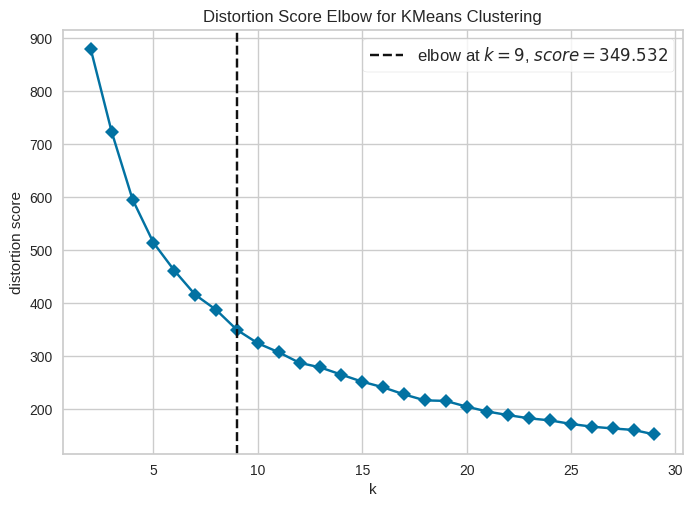

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [139]:
#Elbow criterion for k-means
random.seed(108448)
model_kmeans = KMeans(n_init = 10)

visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False)
visualizer.fit(st_total)
visualizer.show()

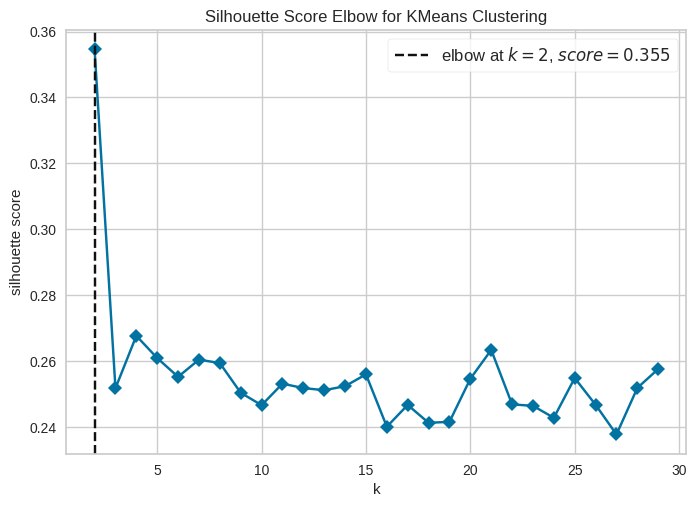

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [140]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric = 'silhouette')
visualizer.fit(st_total)
visualizer.show()

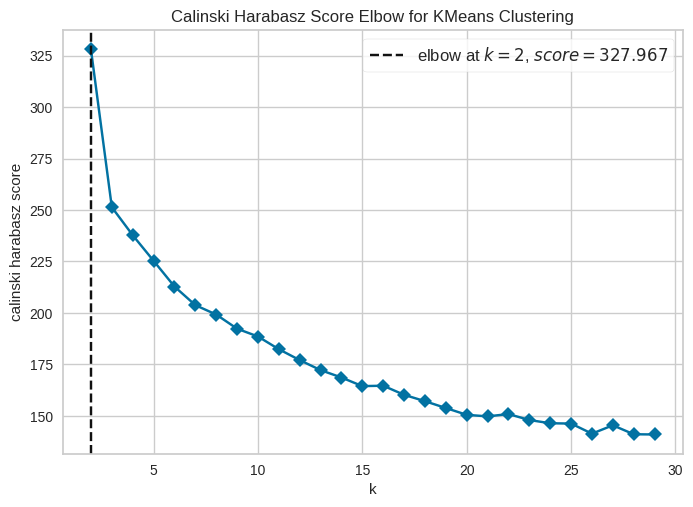

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [141]:
visualizer = KElbowVisualizer(model_kmeans, k = (2, 30), timings = False, metric = 'calinski_harabasz')
visualizer.fit(st_total)
visualizer.show()

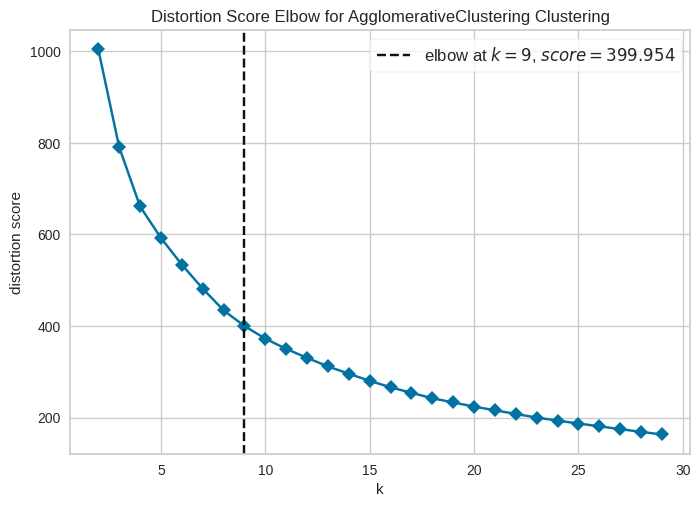

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [142]:
#Elbow criterion
random.seed(108448)
model_hier = AgglomerativeClustering()

visualizer = KElbowVisualizer(model_hier, k = (2, 30), timings = False)
visualizer.fit(st_total)
visualizer.show()

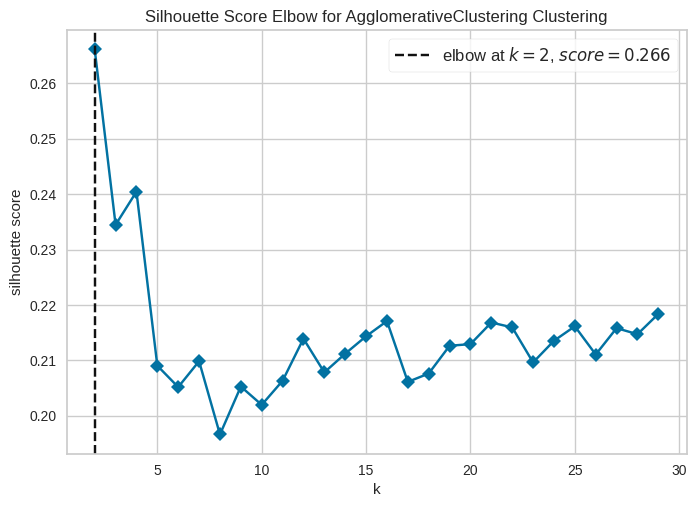

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [143]:
visualizer = KElbowVisualizer(model_hier, k = (2, 30), timings = False, metric = 'silhouette')
visualizer.fit(st_total)
visualizer.show()

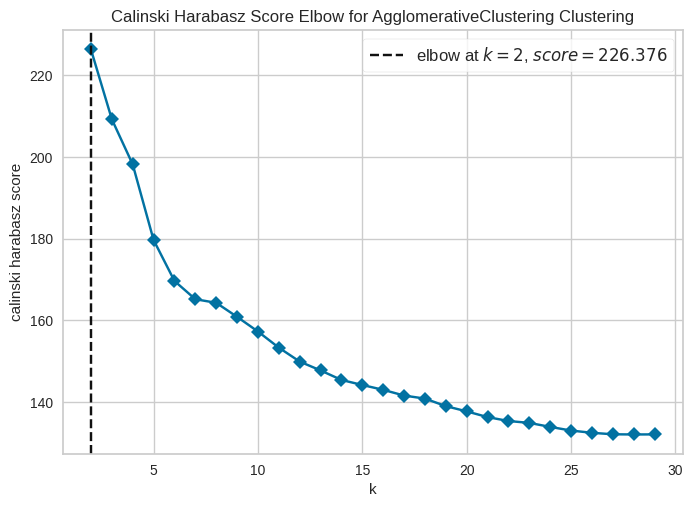

<Axes: title={'center': 'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [144]:
visualizer = KElbowVisualizer(model_hier, k = (2, 30), timings = False, metric = 'calinski_harabasz')
visualizer.fit(st_total)
visualizer.show()

###K-means

In [145]:
#K-means
random.seed(108448)

k2 = 2

diff_kmeans = KMeans(n_clusters = k2)
diff_kmeans.fit(st_total)
total['K-means_z'] = diff_kmeans.labels_
pd.pivot_table(total, index=['K-means_z'], values=['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                                          std  \
          Beta HML Diff Beta Mkt-RF Diff Beta SMB Diff Beta HML Diff   
K-means_z                                                              
0              0.039374        -0.097139     -0.110494      0.254423   
1              0.450057         0.279058      0.229322      0.279130   

                                          
          Beta Mkt-RF Diff Beta SMB Diff  
K-means_z                                 
0                 0.179498      0.208825  
1                 0.205669      0.248726

In [146]:
#Visualizing k-means clustering

x = total['Beta Mkt-RF Diff']
y = total['Beta SMB Diff']
z = total['Beta HML Diff']
color = total['K-means_z'].astype('category')

fig = px.scatter_3d(total, x=x, y=y, z=z,
                    color=color)
fig.show()

###Hierarchical clustering

In [147]:
#Hierarchical clustering

random.seed(108448)

diff_hier = AgglomerativeClustering(n_clusters = k2, metric = 'euclidean', linkage = 'ward')
total['Hier_z'] = diff_hier.fit_predict(st_total)
pd.pivot_table(total, index=['Hier_z'], values=['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff'], aggfunc = ['mean', 'std']) #mean betas for each cluster

mean                                          std  \
       Beta HML Diff Beta Mkt-RF Diff Beta SMB Diff Beta HML Diff   
Hier_z                                                              
0           0.307036         0.197711      0.183463      0.356137   
1           0.065795        -0.139155     -0.185276      0.235827   

                                       
       Beta Mkt-RF Diff Beta SMB Diff  
Hier_z                                 
0              0.225988      0.236165  
1              0.175889      0.176940

In [148]:
#Visualizing hierarchical clustering

x = total['Beta Mkt-RF Diff']
y = total['Beta SMB Diff']
z = total['Beta HML Diff']
color = total['Hier_z'].astype('category')

fig = px.scatter_3d(total, x=x, y=y, z=z,
                    color=color)
fig.show()

###HDBSCAN

In [149]:
random.seed(108448)

diff_hdbscan = hdbscan.HDBSCAN()
diff_hdbscan.fit(st_total)
total['HDBSCAN_z'] = bc_hdbscan.labels_
pd.pivot_table(total, index=['HDBSCAN_z'], values=['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff'], aggfunc = ['mean', 'std']) #mean betas for each cluster

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



mean                                          std  \
          Beta HML Diff Beta Mkt-RF Diff Beta SMB Diff Beta HML Diff   
HDBSCAN_z                                                              
-1             0.127707         0.035359      0.005522      0.337550   
 0              0.24005         0.063889      0.027736      0.324873   
 1            -0.131654        -0.101532        0.2207      0.133129   

                                          
          Beta Mkt-RF Diff Beta SMB Diff  
HDBSCAN_z                                 
-1                0.233975      0.287945  
 0                0.276792      0.279076  
 1                0.130631      0.096458

In [165]:
#Visualizing HDBSCAN clustering

x1 = total.drop(total[total['HDBSCAN_z'] == -1].index)['Beta Mkt-RF Diff']
y1 = total.drop(total[total['HDBSCAN_z'] == -1].index)['Beta SMB Diff']
z1 = total.drop(total[total['HDBSCAN_z'] == -1].index)['Beta HML Diff']
c1 = total[total['HDBSCAN_z'] != -1]['HDBSCAN_z'].astype('category')


x2 = total[total['HDBSCAN_z'] == -1]['Beta Mkt-RF Diff']
y2 = total[total['HDBSCAN_z'] == -1]['Beta SMB Diff']
z2 = total[total['HDBSCAN_z'] == -1]['Beta HML Diff']
c2 = total[total['HDBSCAN_z'] == -1]['HDBSCAN_z']


fig = px.scatter_3d(total, x=x1, y=y1, z=z1, color=c1)

fig.add_trace(
    go.Scatter3d(x=x2, y=y2, z=z2, mode='markers',
        marker=dict(color='gray', size=4, symbol='circle'),
        name='Outliers'))

fig.update_layout(
    scene=dict(
        xaxis_title='Beta Mkt-RF Diff',
        yaxis_title='Beta SMB Diff',
        zaxis_title='Beta HML Diff'
    )
)

fig.show()

###Comparison

In [151]:
methods = ['K-means_z', 'HDBSCAN_z', 'Hier_z']
adjrandscore = pd.DataFrame(columns = methods, index = methods)

print('Adjusted rand score for beta differences:')
for i in methods:
  for j in methods:
    adjrandscore.loc[i, j] = adjusted_rand_score(total[i], total[j])

adjrandscore

Adjusted rand score for beta differences:


,K-means_z,HDBSCAN_z,Hier_z
K-means_z,1.0,-0.013697,0.419584
HDBSCAN_z,-0.013697,1.0,-0.007931
Hier_z,0.419584,-0.007931,1.0


In [152]:
similarity = pd.DataFrame(columns = range(k), index = range(k))

for i in range(k):
  for j in range(k):
    similarity.loc[i, j] = len(pd.merge(total.loc[total['K-means_z'] == i], total.loc[total['Hier_z'] == j], how ='inner', on = 'Ticker'))

print('Similarities between K-means clusters (index) and hierarchical clusters (columns) for beta differences')
similarity

Similarities between K-means clusters (index) and hierarchical clusters (columns) for beta differences


,0,1
0,85,209
1,195,1


In [153]:
similarity = pd.DataFrame(columns = [-1, 0, 1], index = range(k))

for i in range(k):
  for j in [-1, 0, 1]:
    similarity.loc[i, j] = len(pd.merge(total.loc[total['K-means_z'] == i], total.loc[total['HDBSCAN_z'] == j], how ='inner', on = 'Ticker'))

print('Similarities between K-means clusters (index) and HDBSCAN (columns) for beta differences')
similarity

Similarities between K-means clusters (index) and HDBSCAN (columns) for beta differences


,-1,0,1
0,87,199,8
1,42,153,1


In [154]:
similarity = pd.DataFrame(columns = [-1, 0, 1], index = range(k))

for i in range(k):
  for j in [-1, 0, 1]:
    similarity.loc[i, j] = len(pd.merge(total.loc[total['Hier_z'] == i], total.loc[total['HDBSCAN_z'] == j], how ='inner', on = 'Ticker'))

print('Similarities between Hierarchical clustering (index) and HDBSCAN (columns) for beta differences')
similarity

Similarities between Hierarchical clustering (index) and HDBSCAN (columns) for beta differences


,-1,0,1
0,75,196,9
1,54,156,0


###Industries analysis

In [155]:
pd.pivot_table(total, columns=['Hier_x', 'Hier_y'], index = ['GICS Sector'], values = ['Beta HML_x', 'Beta HML_y'], aggfunc = ['mean', pd.Series.nunique])

mean                                           \
                       Beta HML_x                               Beta HML_y   
Hier_x                          0                   1                    0   
Hier_y                          0         1         0         1          0   
GICS Sector                                                                  
Communication Services  -0.458411  0.090913       NaN  0.375341  -0.221635   
Consumer Discretionary  -0.252347 -0.014167  0.089413   0.31259  -0.235603   
Consumer Staples         0.001879  0.108232  0.652451  0.486745   0.119501   
Energy                        NaN   0.34754       NaN  0.827071        NaN   
Financials              -0.150098  0.086704  0.439584  1.099416   0.076105   
Health Care             -0.365884   0.01036  0.295217  0.423947  -0.138442   
Industrials             -0.225472  0.014744  0.386899  0.466827   0.111136   
Information Technology  -0.547987 -0.133558  0.004398  0.185612  -0.356874   
Materials                -0.01748   0.03991       NaN  0.619132   0.150892   
Real Estate             -0.329512 -0.143604       NaN  0.175367  -0.012774   
Utilities               -0.187146 -0.080711  0.447205       NaN    0.23485   

                                                        nunique              \
                                                     Beta HML_x               
Hier_x                                   1                    0           1   
Hier_y                         1         0         1          0     1     0   
GICS Sector                                                                   
Communication Services   0.55943       NaN  0.426022       13.0   4.0   NaN   
Consumer Discretionary  0.422381 -0.191739   0.53649       15.0   9.0   2.0   
Consumer Staples         0.68855   0.15368  0.628784       30.0   3.0   1.0   
Energy                  0.723041       NaN  1.223846        NaN   1.0   NaN   
Financials              0.661043  0.109027    1.0086       26.0   8.0   2.0   
Health Care              0.46513  0.353788  0.537495       52.0   4.0   4.0   
Industrials             0.372315  0.159682  0.611127       16.0   8.0  15.0   
Information Technology  0.248019 -0.162205  0.365981       39.0   5.0  13.0   
Materials               0.461333       NaN  0.709328        9.0   3.0   NaN   
Real Estate             0.634605       NaN  0.674542       14.0  13.0   NaN   
Utilities               0.289083  0.201723       NaN       26.0   2.0   1.0   

                                                           
                             Beta HML_y                    
Hier_x                                0           1        
Hier_y                     1          0     1     0     1  
GICS Sector                                                
Communication Services   4.0       13.0   4.0   NaN   4.0  
Consumer Discretionary  27.0       15.0   9.0   2.0  27.0  
Consumer Staples         2.0       30.0   3.0   1.0   2.0  
Energy                  22.0        NaN   1.0   NaN  22.0  
Financials              35.0       26.0   8.0   2.0  35.0  
Health Care              2.0       52.0   4.0   4.0   2.0  
Industrials             33.0       16.0   8.0  15.0  33.0  
Information Technology   9.0       39.0   5.0  13.0   9.0  
Materials               15.0        9.0   3.0   NaN  15.0  
Real Estate              3.0       14.0  13.0   NaN   3.0  
Utilities                NaN       26.0   2.0   1.0   NaN

In [156]:
pd.pivot_table(total.loc[total['Hier_z'] == 1], columns=['K-means_z'],
                    index = ['GICS Sector'], values = ['Beta Mkt-RF Diff', 'Beta SMB Diff', 'Beta HML Diff'], aggfunc = ['mean', pd.Series.nunique])

mean                                       \
                       Beta HML Diff           Beta Mkt-RF Diff             
K-means_z                          0         1                0         1   
GICS Sector                                                                 
Communication Services      0.193497       NaN        -0.199956       NaN   
Consumer Discretionary     -0.067488       NaN        -0.087799       NaN   
Consumer Staples            0.052063       NaN        -0.052029       NaN   
Energy                      0.185496       NaN         -0.11055       NaN   
Financials                  0.056437       NaN        -0.066946       NaN   
Health Care                 0.119572       NaN        -0.219358       NaN   
Industrials                -0.011677  0.406932        -0.164198  0.202351   
Information Technology      0.087466       NaN        -0.129296       NaN   
Materials                   0.079925       NaN        -0.067292       NaN   
Utilities                  -0.245482       NaN         0.176273       NaN   

                                                     nunique       \
                       Beta SMB Diff           Beta HML Diff        
K-means_z                          0         1             0    1   
GICS Sector                                                         
Communication Services     -0.204947       NaN          11.0  NaN   
Consumer Discretionary     -0.199699       NaN          14.0  NaN   
Consumer Staples           -0.118813       NaN          20.0  NaN   
Energy                     -0.117566       NaN          10.0  NaN   
Financials                  -0.10289       NaN           8.0  NaN   
Health Care                -0.236874       NaN          44.0  NaN   
Industrials                -0.188012 -0.154548          49.0  1.0   
Information Technology     -0.191481       NaN          37.0  NaN   
Materials                  -0.136261       NaN          15.0  NaN   
Utilities                  -0.564478       NaN           1.0  NaN   

                                                                 
                       Beta Mkt-RF Diff      Beta SMB Diff       
K-means_z                             0    1             0    1  
GICS Sector                                                      
Communication Services             11.0  NaN          11.0  NaN  
Consumer Discretionary             14.0  NaN          14.0  NaN  
Consumer Staples                   20.0  NaN          20.0  NaN  
Energy                             10.0  NaN          10.0  NaN  
Financials                          8.0  NaN           8.0  NaN  
Health Care                        44.0  NaN          44.0  NaN  
Industrials                        49.0  1.0          49.0  1.0  
Information Technology             37.0  NaN          37.0  NaN  
Materials                          15.0  NaN          15.0  NaN  
Utilities                           1.0  NaN           1.0  NaN

In [157]:
pd.pivot_table(total.loc[total['Hier_z'] == 1], columns=['K-means_z'],
                    index = ['GICS Sector', 'GICS Sub-Industry'], values = ['Ticker'], aggfunc = pd.Series.nunique)

Ticker  \
K-means_z                                                                  0   
GICS Sector            GICS Sub-Industry                                       
Communication Services Cable & Satellite                                 2.0   
                       Integrated Telecommunication Services             1.0   
                       Interactive Home Entertainment                    3.0   
                       Interactive Media & Services                      3.0   
                       Movies & Entertainment                            1.0   
...                                                                      ...   
Materials              Fertilizers & Agricultural Chemicals              2.0   
                       Paper & Plastic Packaging Products & Materials    4.0   
                       Specialty Chemicals                               5.0   
                       Steel                                             2.0   
Utilities              Multi-Utilities                                   1.0   

                                                                           
K-means_z                                                               1  
GICS Sector            GICS Sub-Industry                                   
Communication Services Cable & Satellite                              NaN  
                       Integrated Telecommunication Services          NaN  
                       Interactive Home Entertainment                 NaN  
                       Interactive Media & Services                   NaN  
                       Movies & Entertainment                         NaN  
...                                                                    ..  
Materials              Fertilizers & Agricultural Chemicals           NaN  
                       Paper & Plastic Packaging Products & Materials NaN  
                       Specialty Chemicals                            NaN  
                       Steel                                          NaN  
Utilities              Multi-Utilities                                NaN  

[75 rows x 2 columns]

In [158]:
# df = pd.pivot_table(total, index = ['GICS Sector', 'GICS Sub-Industry'], columns = 'K-means_z', values = ['Ticker'], aggfunc = pd.Series.nunique)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

In [159]:
#Computing Euclidean distances for beta-differences
for i in range(len(total)):
  total.loc[i, 'Distance'] = math.dist([0, 0, 0], [total.loc[i, 'Beta HML Diff'], total.loc[i, 'Beta Mkt-RF Diff'], total.loc[i, 'Beta SMB Diff']])
total

,Beta Mkt-RF_x,Beta SMB_x,Beta HML_x,Hier_x,K-means_x,HDBSCAN_x,Security,GICS Sector,GICS Sub-Industry,Ticker,...,Hier_y,K-means_y,HDBSCAN_y,Beta Mkt-RF Diff,Beta SMB Diff,Beta HML Diff,K-means_z,Hier_z,HDBSCAN_z,Distance
0,1.104099,-0.008052,-0.232202,0,1,0,Agilent Technologies,Health Care,Health Care Equipment,A,...,0,0,0,-0.170108,-0.04598,0.002813,0,1,0,0.176236
1,1.467816,0.59704,0.379124,1,0,-1,American Airlines Group,Industrials,Passenger Airlines,AAL,...,1,1,-1,0.123292,0.601208,0.766289,1,0,-1,0.981759
2,0.786409,0.386944,0.296801,1,0,0,Advance Auto Parts,Consumer Discretionary,Automotive Retail,AAP,...,1,0,0,0.066885,-0.321391,-0.023421,0,1,0,0.329111
3,1.293202,-0.126728,-0.430565,0,1,-1,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",AAPL,...,0,0,1,-0.06291,-0.292132,0.065309,0,1,-1,0.305882
4,1.015654,-0.24661,-0.118949,0,1,0,AbbVie,Health Care,Pharmaceuticals,ABBV,...,0,0,0,-0.548519,-0.114855,0.184195,0,1,0,0.589909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,0.592636,-0.562231,-0.228679,0,1,0,Yum! Brands,Consumer Discretionary,Restaurants,YUM,...,0,0,0,0.131906,0.445211,0.384344,1,0,0,0.602771
486,0.855192,-0.012141,-0.248675,0,1,0,Zimmer Biomet,Health Care,Health Care Equipment,ZBH,...,1,0,0,0.085577,0.180309,0.568373,1,0,0,0.602398
487,1.306125,1.041292,-0.432578,1,0,-1,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,ZBRA,...,0,1,0,0.029653,-0.918056,0.350024,0,1,-1,0.982966
488,1.171605,0.531263,1.36043,1,0,-1,Zions Bancorporation,Financials,Regional Banks,ZION,...,1,1,0,0.210048,0.074596,-0.004383,0,0,-1,0.222944


In [160]:
df = total
df.sort_values('Distance', ascending = False)

,Beta Mkt-RF_x,Beta SMB_x,Beta HML_x,Hier_x,K-means_x,HDBSCAN_x,Security,GICS Sector,GICS Sub-Industry,Ticker,...,Hier_y,K-means_y,HDBSCAN_y,Beta Mkt-RF Diff,Beta SMB Diff,Beta HML Diff,K-means_z,Hier_z,HDBSCAN_z,Distance
314,1.097917,0.295933,0.13936,1,0,0,Norwegian Cruise Line Holdings,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",NCLH,...,1,1,-1,0.903684,1.282551,1.025904,1,0,0,1.874583
82,0.99228,0.251636,0.305787,1,0,0,Carnival,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",CCL,...,1,1,-1,0.989624,1.202297,0.892343,1,0,0,1.794756
377,1.198133,0.206112,0.076035,1,0,0,Royal Caribbean Group,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",RCL,...,1,1,-1,0.624146,0.990184,1.021813,1,0,0,1.553745
460,0.158007,-0.237999,-0.405874,0,1,0,Ventas,Real Estate,Health Care REITs,VTR,...,1,1,0,0.855328,0.512683,1.160084,1,0,0,1.529780
443,1.015242,0.319607,0.304217,1,0,0,United Airlines Holdings,Industrials,Passenger Airlines,UAL,...,1,1,-1,0.690441,0.76761,1.001853,1,0,0,1.438626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.297843,-0.356801,0.098478,0,1,0,Campbell Soup Company,Consumer Staples,Packaged Foods & Meats,CPB,...,0,0,0,-0.029581,0.065822,-0.005197,0,1,0,0.072350
96,0.905912,-0.124397,0.229873,0,1,0,Comcast,Communication Services,Cable & Satellite,CMCSA,...,0,0,0,-0.047213,-0.048665,-0.017989,0,1,0,0.070150
50,1.037423,0.800753,-0.525402,0,0,-1,Axon Enterprise,Industrials,Aerospace & Defense,AXON,...,1,1,-1,-0.037633,0.027208,-0.048385,0,1,-1,0.067064
438,1.011862,-0.034831,0.269761,0,0,0,Trane Technologies,Industrials,Building Products,TT,...,1,0,0,-0.018235,0.039991,0.018215,0,1,0,0.047577
